# Weather Forecasting - Time series 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt

## Data loading and EDA

In [3]:
import pandas as pd

In [4]:
train_data = pd.read_csv('DailyDelhiClimateTrain.csv')

In [5]:
# load train dataset

train_data['date']=pd.to_datetime(train_data['date'])
train_data.set_index('date',inplace=True)

In [6]:
train_data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [7]:
train_data.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [8]:
# load test data set
test_data = pd.read_csv('DailyDelhiClimateTest.csv')

In [9]:
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date',inplace=True)

In [10]:
test_data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


<Axes: xlabel='date'>

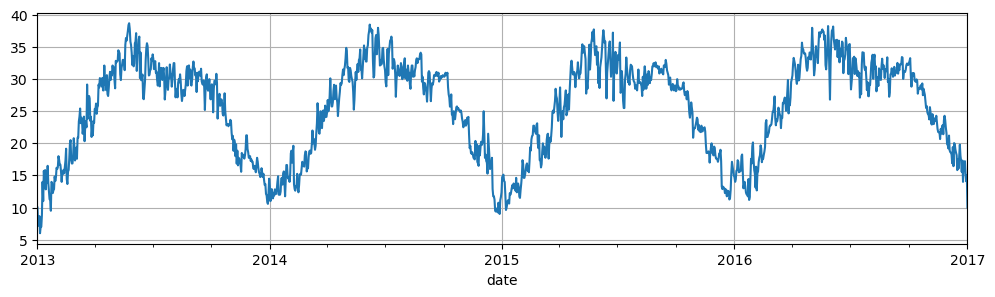

In [12]:
train_data['meantemp'].plot(figsize=(12,3),grid=True)

In [13]:
# monthly resampling of temperature - train data
monthly_train_data = train_data['meantemp'].resample('M').mean()

In [14]:
monthly_train_data = train_data['meantemp'].resample('M').mean()

<Axes: xlabel='date'>

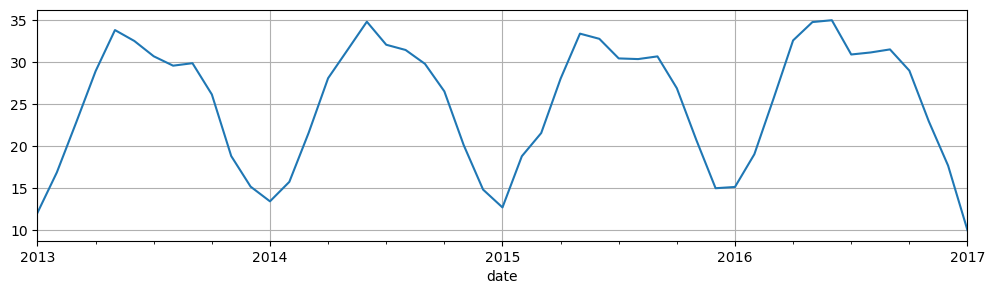

In [15]:
monthly_train_data.plot(figsize=(12,3),grid=True)

In [16]:
# monthly resampling of temperature - test data
monthly_test_data = test_data['meantemp'].resample('M').mean()

<Axes: xlabel='date'>

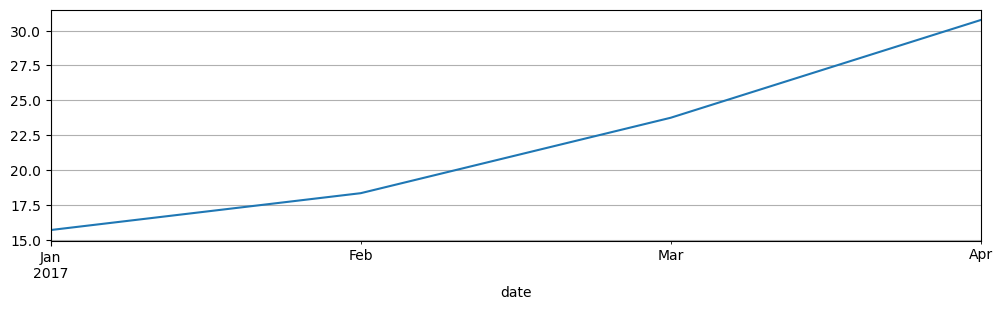

In [17]:
monthly_test_data.plot(figsize=(12,3),grid=True)

<Axes: xlabel='date'>

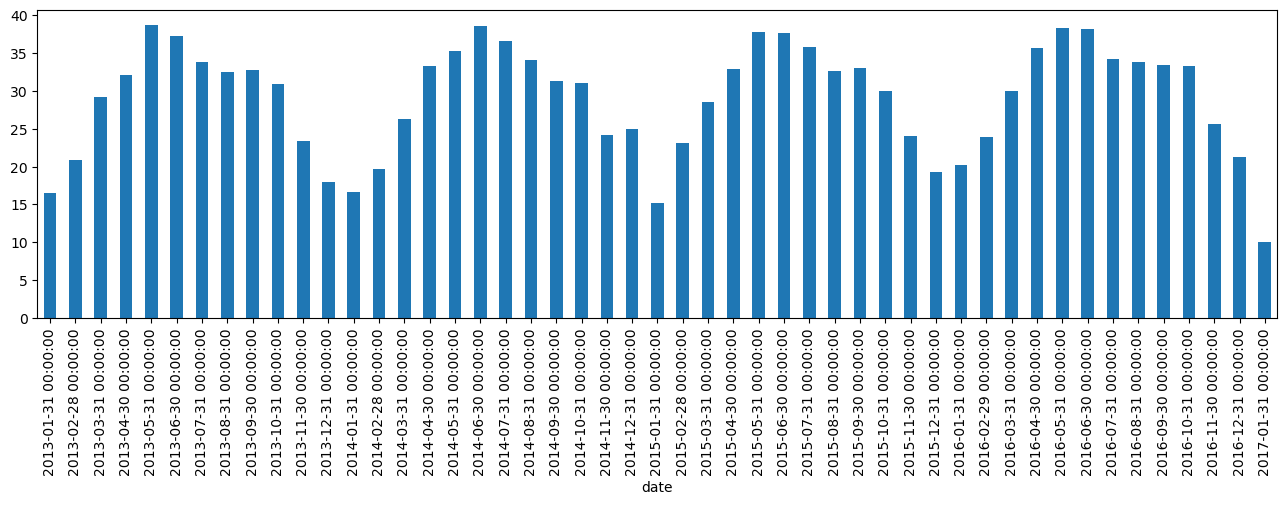

In [18]:
#month end analysis
train_data['meantemp'].resample('M').max().plot(kind='bar',figsize=(16,4))

In [19]:
train_data['meantemp:20 days rolling']=train_data['meantemp'].rolling(20).mean()

<Axes: xlabel='date'>

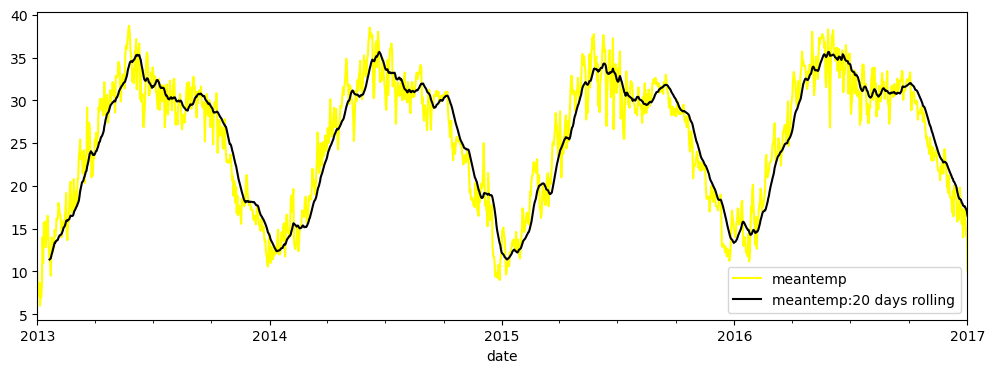

In [20]:
# rolling mean for handling fluctuations
train_data[['meantemp','meantemp:20 days rolling']].plot(figsize=(12,4),color=['yellow','black'])

## Time series decomposition

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
decomposition = seasonal_decompose(monthly_train_data, model='additive')

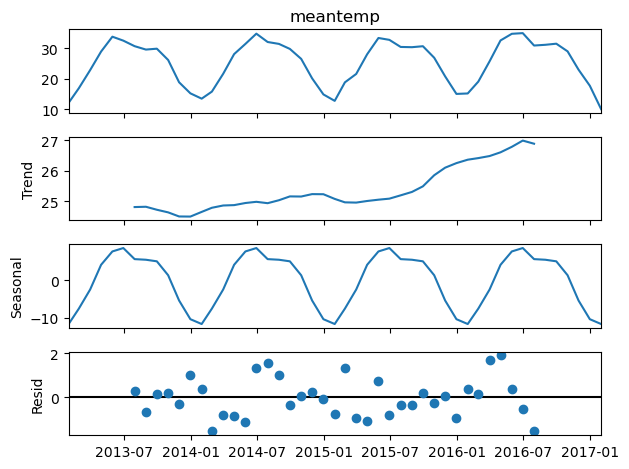

In [23]:
decomposition.plot()
plt.show()

## Stationarity check - ADF Test

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
def test(series):
    result = adfuller(series)
    print(result)
    print("ADF statistics :",result[0])
    print("p-val :",result[1])
    if result[1] <= 0.05:
        print("Reject Null hypothesis,It is stationary data")
    else:
        print("Failed to reject null hypothesis,It is not stationary data")

In [26]:
test(monthly_train_data)

(-1.0462204206798986, 0.736035605058913, 10, 38, {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}, 154.258413240739)
ADF statistics : -1.0462204206798986
p-val : 0.736035605058913
Failed to reject null hypothesis,It is not stationary data


## Differencing 

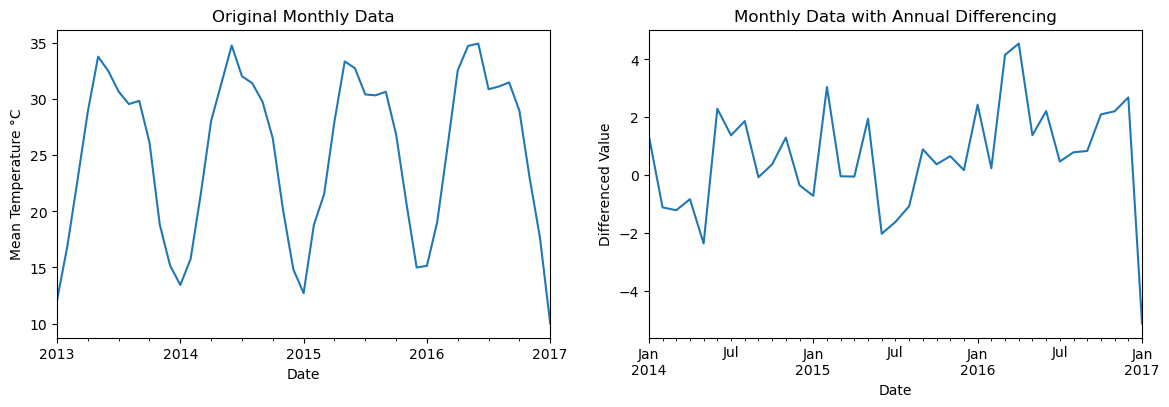

In [27]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

#original data
monthly_train_data.plot(ax=ax[0])
ax[0].set_title('Original Monthly Data')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Temperature °C')

# after differencing for 12 months
monthly_train_data.diff(periods=12).dropna().plot(ax=ax[1])
ax[1].set_title('Monthly Data with Annual Differencing')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Differenced Value')
plt.show()


In [28]:
test(monthly_train_data.diff().dropna())

(-7.2758684401062546, 1.5450729805971367e-10, 9, 38, {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}, 152.99503872520177)
ADF statistics : -7.2758684401062546
p-val : 1.5450729805971367e-10
Reject Null hypothesis,It is stationary data


## ACF and PACF plots

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

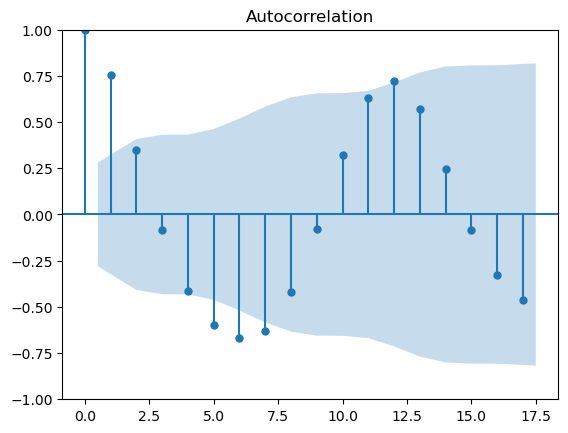

In [30]:
# ACF plot for Q value

plot_acf(monthly_train_data)
plt.show()

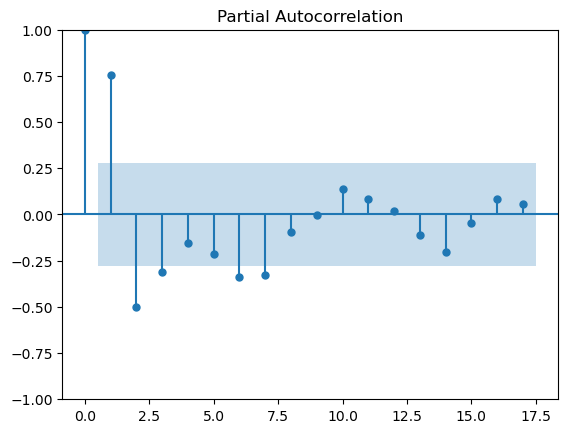

In [31]:
#PACF plot for P value
plot_pacf(monthly_train_data)
plt.show()

## SARIMA modelling with automated model selection

In [32]:
# Importing pmdarima - it is a library that identifies optimal SARIMA - p q d values
import pmdarima as pm

# finding best model for sarima 
best_model = pm.auto_arima(monthly_train_data,
                      seasonal=True, m=12,
                      start_p=0, start_q=0,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      stepwise=True,
                      error_action='ignore',
                      suppress_warnings=True) 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=149.017, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=154.686, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=147.633, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=156.606, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=155.971, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=147.522, Time=0.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=149.432, Time=0.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=147.497, Time=0.15 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=149.432, Time=0.33 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=147.449, Time=0.19 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=148.932, Time=0.14 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=14

In [33]:
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                   49
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 -68.565
Date:                                 Mon, 13 Nov 2023   AIC                            147.131
Time:                                         22:02:41   BIC                            155.185
Sample:                                     01-31-2013   HQIC                           149.970
                                          - 01-31-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5113      0.214      2.387      0.017       0.092       0

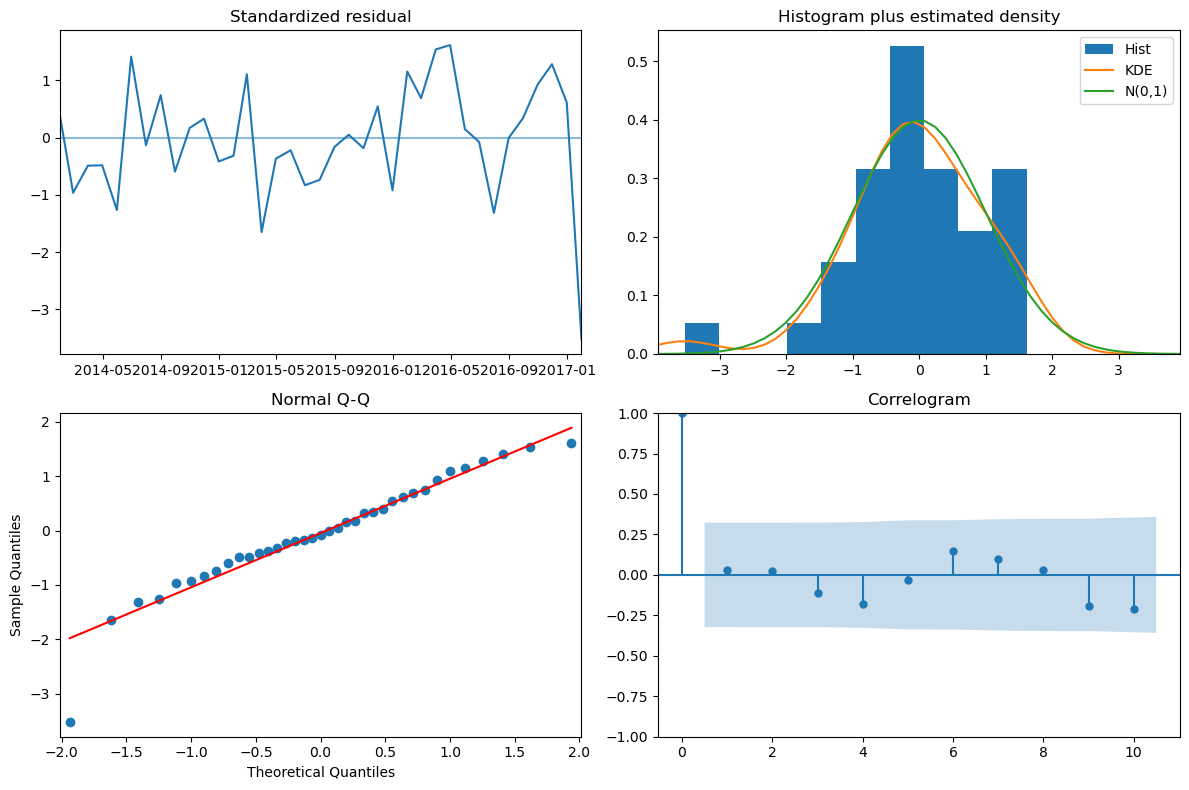

In [34]:
fig = best_model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

## Forecasting

In [35]:
# forecasting for the next 12 months 
forecast_values, conf_int = best_model.predict(n_periods=len(monthly_test_data)+12, return_conf_int=True)

In [36]:
forecast_index = forecast_values.index

In [37]:
# creating data frame for forecasting values

forecast_series = pd.Series(forecast_values, index=forecast_index)
lower_series = pd.Series(conf_int[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int[:, 1], index=forecast_index)

In [38]:
forecast_series

2017-02-28    16.811957
2017-03-31    22.994857
2017-04-30    29.398913
2017-05-31    33.928604
2017-06-30    34.879727
2017-07-31    32.485044
2017-08-31    32.044024
2017-09-30    31.533211
2017-10-31    27.944194
2017-11-30    21.565336
2017-12-31    16.234416
2018-01-31    15.403103
2018-02-28    20.008772
2018-03-31    24.817828
2018-04-30    31.524649
2018-05-31    35.017516
Freq: M, dtype: float64

<Axes: >

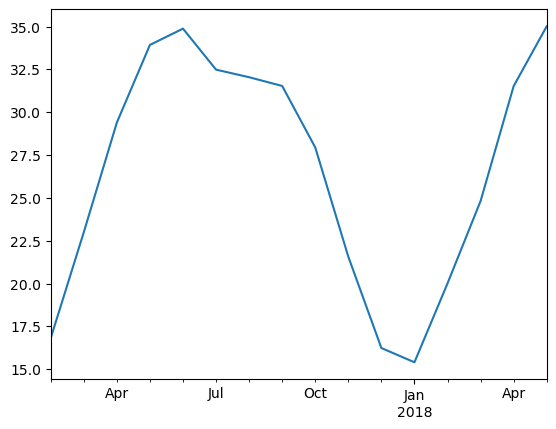

In [39]:
forecast_series.plot()

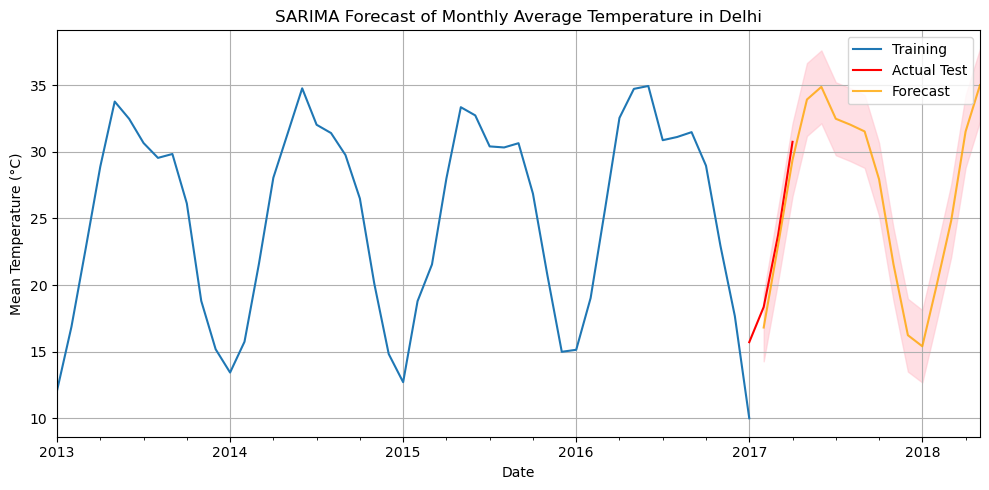

In [40]:
# Plot the actual vs predicted values

plt.figure(figsize=(10, 5))
monthly_train_data.plot(label='Training', legend=True)
monthly_test_data.plot(label='Actual Test', legend=True, color='red')
forecast_series.plot(label='Forecast', legend=True, color='orange', alpha=0.8)
plt.fill_between(forecast_index, lower_series, upper_series, color='pink', alpha=0.5)
plt.title('SARIMA Forecast of Monthly Average Temperature in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Evaluvtion

In [41]:
from sklearn.metrics import mean_absolute_error


In [42]:
# Calculate the mean absolute error
mae = mean_absolute_error(monthly_test_data, forecast_values[:len(monthly_test_data)])


In [43]:
print(mae)

3.6415132714124554


### This means that our model is 3.64 °C away from actual monthly average temperatures 

## Summary

#### The SARIMA model has provided a reasonable forecast for the monthly average temperatures in Delhi for the test data duration and beyond 12 months.
#### The confidence intervals provide a range of plausible values for the forecasts, indicating the certainty associated with the predictions.